In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft,irfft
from matplotlib.colors import LogNorm
from itertools import combinations
import sys, os

parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
import telescope_1d

0.19970703125
-0.19970703125


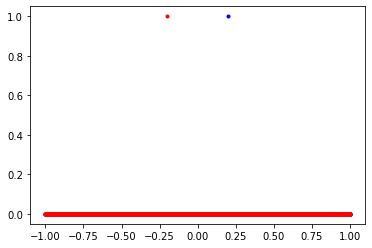

In [2]:
t = telescope_1d.Telescope1D()

# Sky with point source at alpha
image1 = t.empty_image()
ndx1 = int(t.Npix*60/100)
image1[ndx1] = 1

# Point source at negative alpha
image2 = t.empty_image()
ndx2 = -1*ndx1-1
image2[ndx2] = 1

# Confirm that the indices are right
print(t.alpha[ndx1])
print(t.alpha[ndx2])

plt.plot(t.alpha,image1,'b.')
plt.plot(t.alpha,image2,'r.')
plt.show()

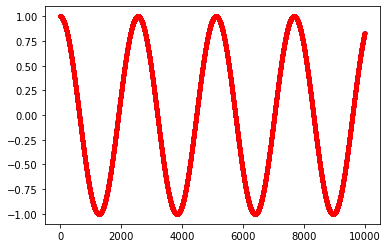

In [3]:
uv1 = t.image2uv(image1)
uv2 = t.image2uv(image2)

# Real part should be the same
plt.plot(np.real(uv1)[100000:100000+10000],'b.')
plt.plot(np.real(uv2)[100000:100000+10000],'r.')
plt.show()

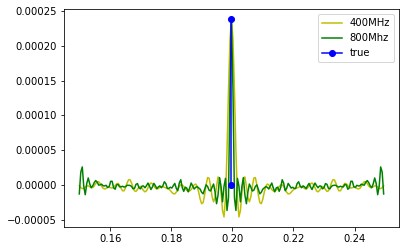

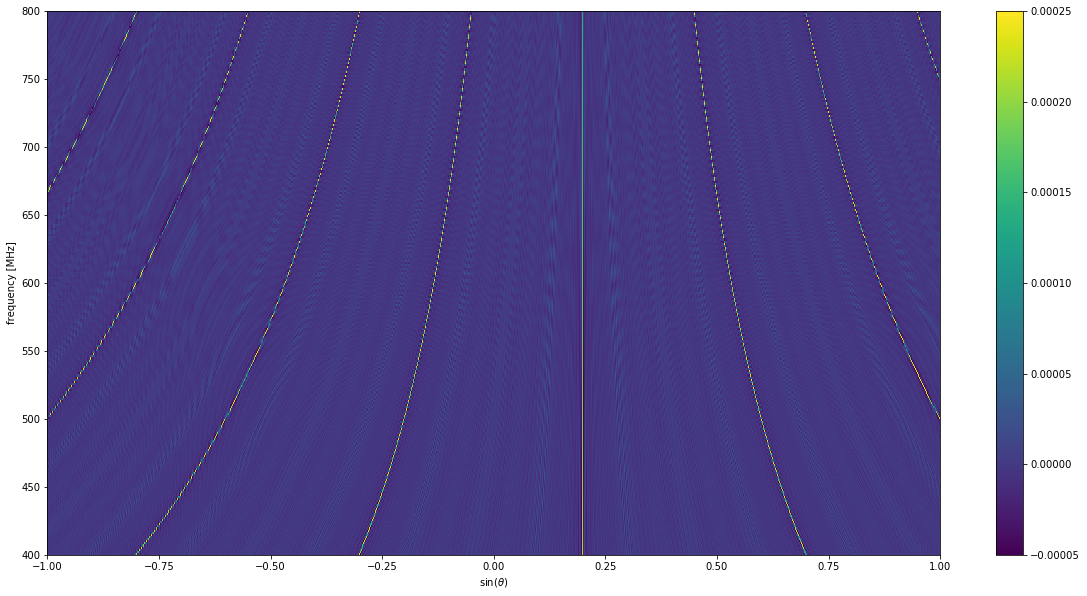

/usr/lib/python3/dist-packages/numpy/fft/_pocketfft.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


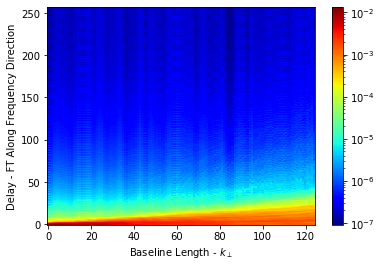

In [4]:
uvplane = t.uv2uvplane(uv1, indices=None)
al = t.alpha[ndx1]
wal = np.where((t.alpha>al-0.05) & (t.alpha<al+0.05))

# For no phase/time error
rmap_no_error = t.get_obs_rmap(uvplane, time_error_sigma=0)

plt.plot(t.alpha[wal],rmap_no_error[0,wal[0]],'y-',label='400MHz')
plt.plot(t.alpha[wal],rmap_no_error[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_no_error.max()],'bo-',label='true')
plt.legend()
plt.show()

t.plot_rmap(rmap_no_error, vmax=0.00025, vmin=-0.00005)
wedge_no_error = t.plot_wedge(Nreal=50, time_error_sigma=0)

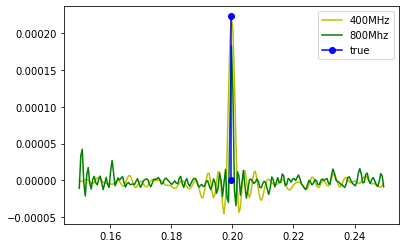

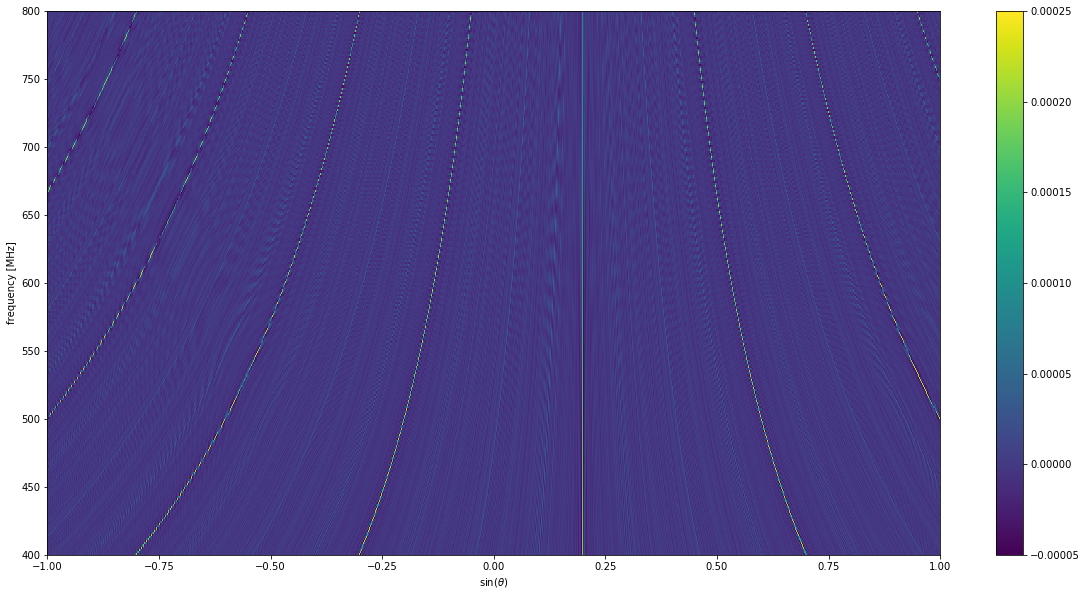

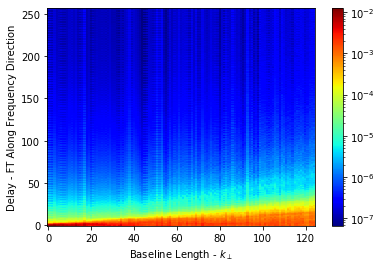

In [5]:
# Try different timing errors
error = 100e-12 # Default for get_obs_rmap is 10 picoseconds, or 10e-12 seconds, which is pretty small; try 100 picoseconds
rmap_100ps = t.get_obs_rmap(uvplane, time_error_sigma=error)

plt.plot(t.alpha[wal],rmap_100ps[0,wal[0]],'y-',label='400MHz')
plt.plot(t.alpha[wal],rmap_100ps[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_100ps.max()],'bo-',label='true')
plt.legend()
plt.show()

t.plot_rmap(rmap_100ps, vmax=0.00025, vmin=-0.00005)
wedge_100ps = t.plot_wedge(Nreal=50, time_error_sigma=error)

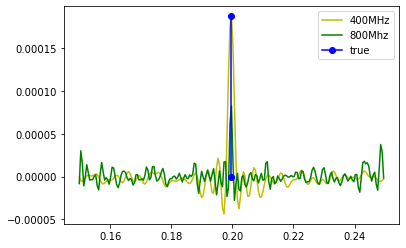

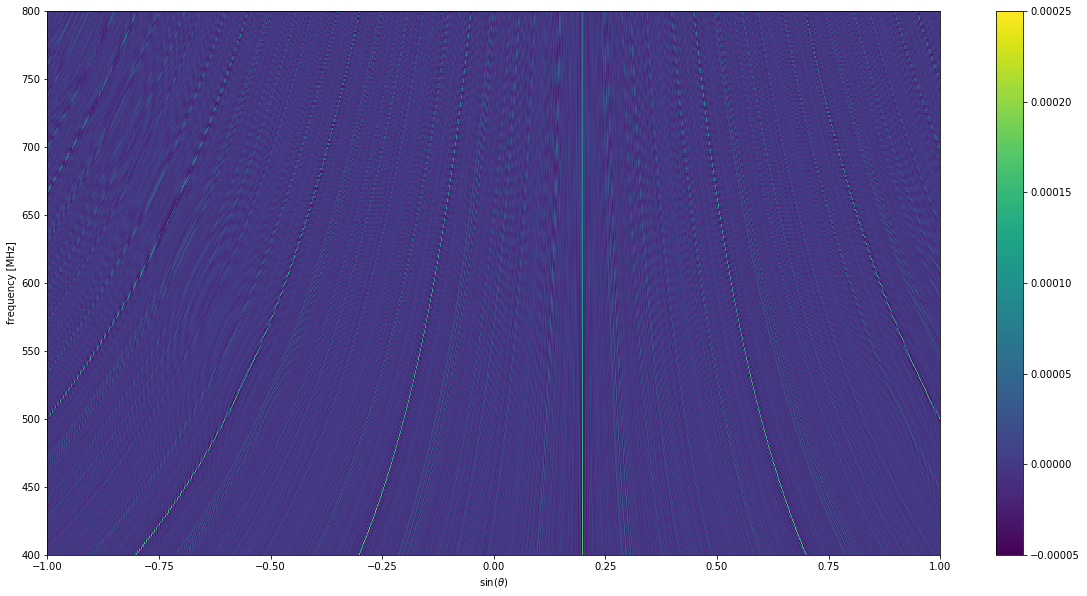

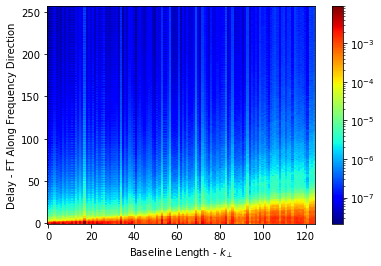

In [6]:
error = 200e-12 # Try 200 picoseconds
rmap_200ps = t.get_obs_rmap(uvplane, time_error_sigma=error)

plt.plot(t.alpha[wal],rmap_200ps[0,wal[0]],'y-',label='400MHz')
plt.plot(t.alpha[wal],rmap_200ps[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_200ps.max()],'bo-',label='true')
plt.legend()
plt.show()

t.plot_rmap(rmap_200ps, vmax=0.00025, vmin=-0.00005)
wedge_200ps = t.plot_wedge(Nreal=50, time_error_sigma=error)

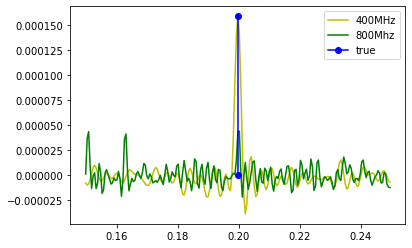

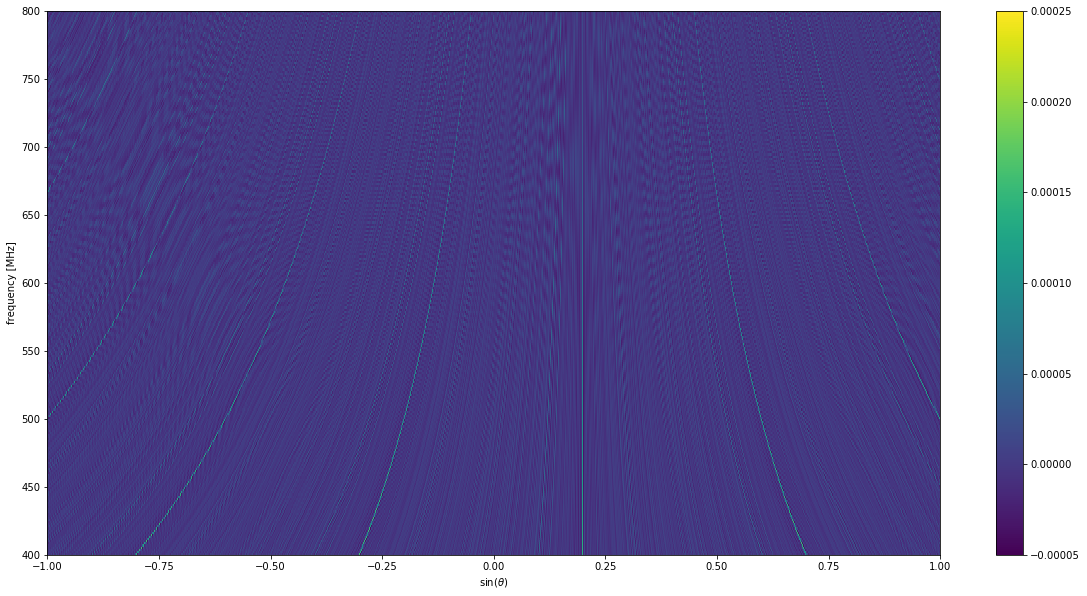

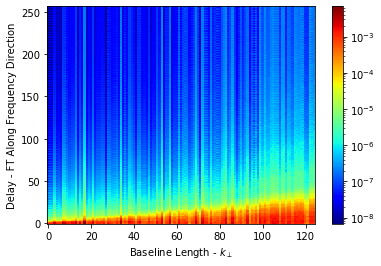

In [7]:
error = 300e-12 # Try 300 picoseconds
rmap_300ps = t.get_obs_rmap(uvplane, time_error_sigma=error)

plt.plot(t.alpha[wal],rmap_300ps[0,wal[0]],'y-',label='400MHz')
plt.plot(t.alpha[wal],rmap_300ps[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_300ps.max()],'bo-',label='true')
plt.legend()
plt.show()

t.plot_rmap(rmap_300ps, vmax=0.00025, vmin=-0.00005)
wedge_300ps = t.plot_wedge(Nreal=50, time_error_sigma=error)

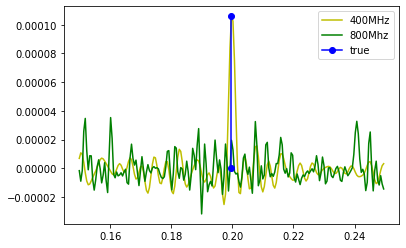

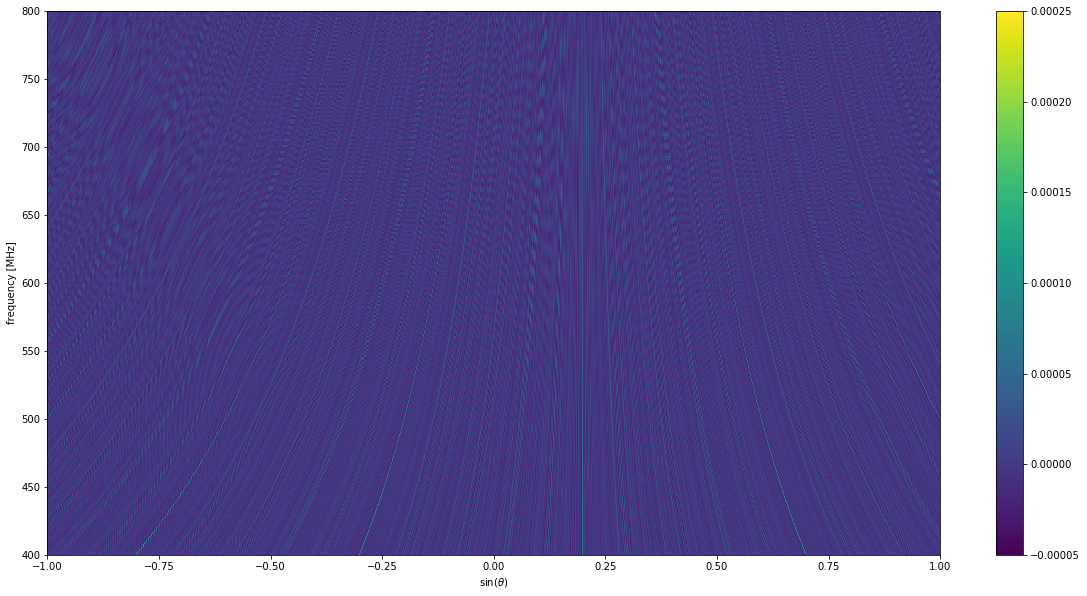

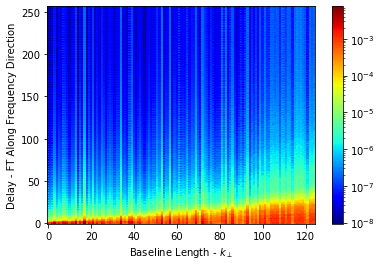

In [8]:
error = 400e-12 # Try 400 picoseconds
rmap_400ps = t.get_obs_rmap(uvplane, time_error_sigma=error)

plt.plot(t.alpha[wal],rmap_400ps[0,wal[0]],'y-',label='400MHz')
plt.plot(t.alpha[wal],rmap_400ps[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_400ps.max()],'bo-',label='true')
plt.legend()
plt.show()

t.plot_rmap(rmap_400ps, vmax=0.00025, vmin=-0.00005)
wedge_400ps = t.plot_wedge(Nreal=50, time_error_sigma=error)

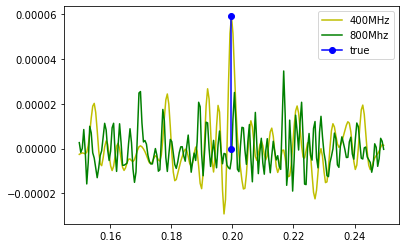

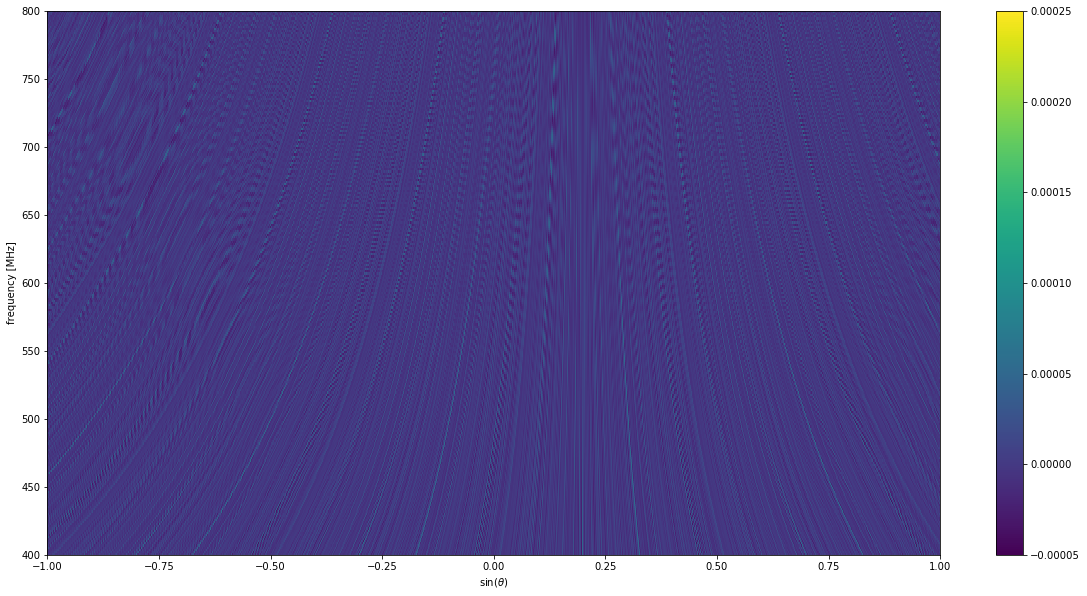

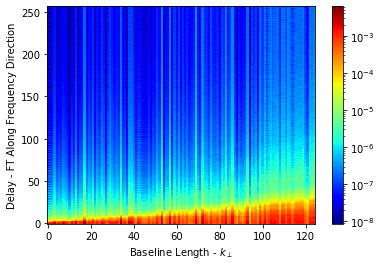

In [9]:
error = 500e-12 # Try 500 picoseconds
rmap_500ps = t.get_obs_rmap(uvplane, time_error_sigma=error)

plt.plot(t.alpha[wal],rmap_500ps[0,wal[0]],'y-',label='400MHz')
plt.plot(t.alpha[wal],rmap_500ps[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_500ps.max()],'bo-',label='true')
plt.legend()
plt.show()

t.plot_rmap(rmap_500ps, vmax=0.00025, vmin=-0.00005)
wedge_500ps = t.plot_wedge(Nreal=50, time_error_sigma=error)